In [14]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import argparse
from JBF import Joint_bilateral_filter

In [15]:
arr = np.array([[1,2,3],[4,5,6],[7,8,9]])
arr2 = arr * 2
arr2[0,0] = 100
print(arr)
print(arr2)

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[100   4   6]
 [  8  10  12]
 [ 14  16  18]]


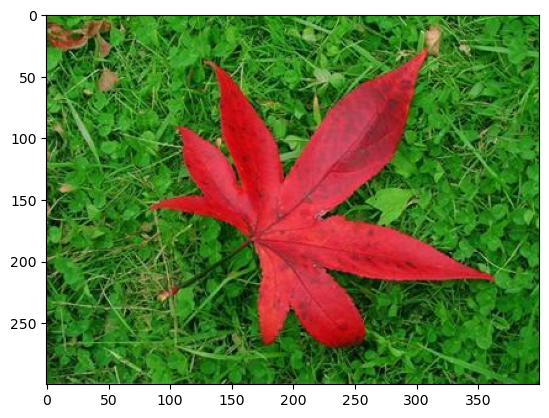

In [16]:
img = cv2.imread("testdata/1.png")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# grayGuidance = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
grayGuidance = (0.8 * img_rgb[:,:,0] + 0.2 * img_rgb[:,:,1] + 0.0 * img_rgb[:,:,2]).clip(0, 255).astype(np.uint8)
plt.imshow(img_rgb)

In [17]:
img_rgb.max()

255

In [18]:
sigma_r = 0.1
sigma_s = 2
wndw_size = 6*sigma_s+1
pad_w = 3*sigma_s

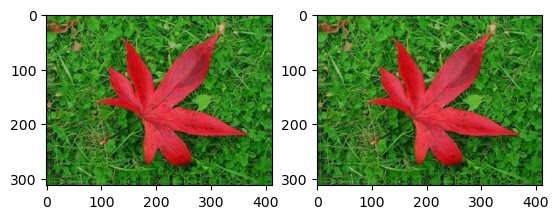

In [19]:
BORDER_TYPE = cv2.BORDER_REFLECT
padded_img = cv2.copyMakeBorder(img_rgb, pad_w, pad_w, pad_w,pad_w, BORDER_TYPE).astype(np.int32)
padded_guidance = cv2.copyMakeBorder(img_rgb, pad_w, pad_w, pad_w, pad_w, BORDER_TYPE).astype(np.int32)
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(padded_img)
fig.add_subplot(1,2,2)
plt.imshow(padded_guidance)

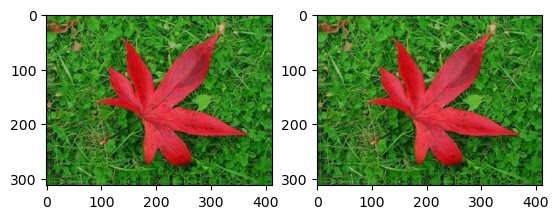

In [20]:
imageForFilter = padded_img / 255.0
guidanceForFilter = padded_guidance / 255.0
width = imageForFilter.shape[1]
height = imageForFilter.shape[0]
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(imageForFilter)
fig.add_subplot(1,2,2)
plt.imshow(guidanceForFilter)

In [21]:
guidenceIsGray = False
if len(np.squeeze(img_rgb).shape) < 3:
    guidenceIsGray = True
print(guidenceIsGray)

False


In [22]:
#create spatial kernel
spatialKernel = np.zeros((wndw_size,wndw_size, 3))
for i in range(-wndw_size//2, wndw_size//2+1):
    for j in range(-wndw_size//2, wndw_size//2+1):
        spatialKernel[i+wndw_size//2 ,j+wndw_size//2,:] = np.repeat(np.exp(-((i**2+j**2)/(2*(sigma_s**2)))),repeats=3)

print(spatialKernel.shape)
print(spatialKernel)

(13, 13, 3)
[[[1.23409804e-04 1.23409804e-04 1.23409804e-04]
  [4.88095244e-04 4.88095244e-04 4.88095244e-04]
  [1.50343919e-03 1.50343919e-03 1.50343919e-03]
  [3.60656314e-03 3.60656314e-03 3.60656314e-03]
  [6.73794700e-03 6.73794700e-03 6.73794700e-03]
  [9.80365504e-03 9.80365504e-03 9.80365504e-03]
  [1.11089965e-02 1.11089965e-02 1.11089965e-02]
  [9.80365504e-03 9.80365504e-03 9.80365504e-03]
  [6.73794700e-03 6.73794700e-03 6.73794700e-03]
  [3.60656314e-03 3.60656314e-03 3.60656314e-03]
  [1.50343919e-03 1.50343919e-03 1.50343919e-03]
  [4.88095244e-04 4.88095244e-04 4.88095244e-04]
  [1.23409804e-04 1.23409804e-04 1.23409804e-04]]

 [[4.88095244e-04 4.88095244e-04 4.88095244e-04]
  [1.93045414e-03 1.93045414e-03 1.93045414e-03]
  [5.94621736e-03 5.94621736e-03 5.94621736e-03]
  [1.42642339e-02 1.42642339e-02 1.42642339e-02]
  [2.66490973e-02 2.66490973e-02 2.66490973e-02]
  [3.87742078e-02 3.87742078e-02 3.87742078e-02]
  [4.39369336e-02 4.39369336e-02 4.39369336e-02]
  [3.8

In [23]:
 # strat the convolution
output = np.zeros_like(img, dtype=np.float64)

for h in range(wndw_size//2 , height - wndw_size//2):
    for w in range(wndw_size//2, width - wndw_size//2):
        #get the window for the current pixel
        window = imageForFilter[h-wndw_size//2:h+wndw_size//2+1, w-wndw_size//2:w+wndw_size//2+1]
        guidanceWindow = guidanceForFilter[h-wndw_size//2:h+wndw_size//2+1, w-wndw_size//2:w+wndw_size//2+1]

        if guidenceIsGray:
            rangeKernel = np.repeat(np.exp(-((guidanceWindow - guidanceForFilter[h,w])**2)/(2*sigma_r**2))[:,:,np.newaxis],axis=2,repeats=3)
        else:
            rangeKernel =  np.repeat(np.exp(-(np.sum((guidanceWindow - guidanceForFilter[h,w])**2, axis= 2))/(2*sigma_r**2))[:,:,np.newaxis],axis=2,repeats=3)

        # normalize factor of the kernels
        normalizeFactor = 1 / np.sum(spatialKernel * rangeKernel, axis=(0,1))

        output[h-wndw_size//2,w-wndw_size//2] = np.sum(spatialKernel * rangeKernel * window, axis=(0,1)) * normalizeFactor

246
0


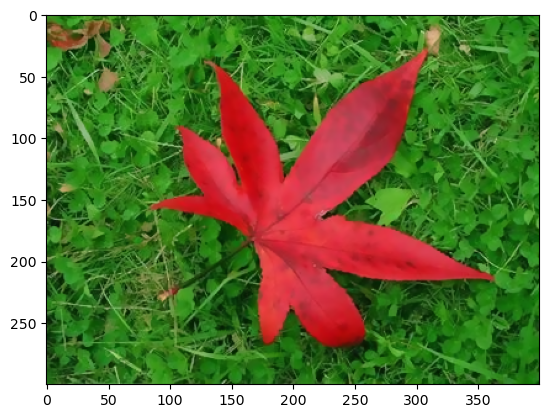

In [24]:
output = output * 255
bf_out =  np.clip(output, 0, 255).astype(np.uint8)
print(bf_out.max())
print(bf_out.min())
plt.imshow(bf_out)

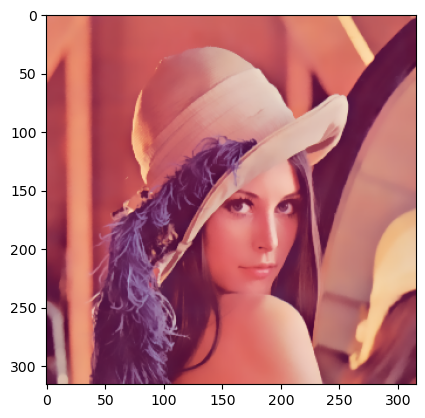

In [25]:
bf_gt = cv2.cvtColor(cv2.imread("testdata/ex_gt_bf.png"), cv2.COLOR_BGR2RGB)
plt.imshow(bf_gt)

In [26]:
bf_error = np.sum(np.abs(bf_out.astype('int32')-bf_gt.astype('int32'))!=0)
bf_error2 = np.sum(bf_out.astype('int32')!=bf_gt.astype('int32'))
print(bf_error)
print(bf_error2)

ValueError: operands could not be broadcast together with shapes (300,400,3) (316,316,3) 

In [ ]:
for i in range(3):
    print(np.sum(bf_out[:,:,i]-bf_gt[:,:,i]))